In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
# import warnings
# warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import RandomOverSampler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve
import pycaret
from pycaret.classification import ClassificationExperiment


In [49]:
# Load the dataset
# Replace 'your_dataset.csv' with the actual file path or URL of your dataset
df = pd.read_csv(r'C:\Users\Akhand Pratap Singh\Desktop\Scroing\notebook\data\bank.csv', sep=';')

In [50]:
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown,no
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,no
4518,57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,-1,0,unknown,no
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,no


In [51]:
object_columns_with_unknown = df.select_dtypes(include=['object']).columns
for column in object_columns_with_unknown:
    unique_values = df[column].unique()
    print(f'Unique values in "{column} " : {unique_values}')

Unique values in "job " : ['unemployed' 'services' 'management' 'blue-collar' 'self-employed'
 'technician' 'entrepreneur' 'admin.' 'student' 'housemaid' 'retired'
 'unknown']
Unique values in "marital " : ['married' 'single' 'divorced']
Unique values in "education " : ['primary' 'secondary' 'tertiary' 'unknown']
Unique values in "default " : ['no' 'yes']
Unique values in "housing " : ['no' 'yes']
Unique values in "loan " : ['no' 'yes']
Unique values in "contact " : ['cellular' 'unknown' 'telephone']
Unique values in "month " : ['oct' 'may' 'apr' 'jun' 'feb' 'aug' 'jan' 'jul' 'nov' 'sep' 'mar' 'dec']
Unique values in "poutcome " : ['unknown' 'failure' 'other' 'success']
Unique values in "y " : ['no' 'yes']


In [52]:
# Encoding Objective
def object_to_int(dataframe_series):
    if dataframe_series.dtype=='object':
        dataframe_series = LabelEncoder().fit_transform(dataframe_series)
    return dataframe_series

In [69]:
df = df.apply(lambda x: object_to_int(x))
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4209 entries, 0 to 4519
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   age        4209 non-null   int64
 1   job        4209 non-null   int32
 2   marital    4209 non-null   int32
 3   education  4209 non-null   int32
 4   default    4209 non-null   int32
 5   balance    4209 non-null   int64
 6   housing    4209 non-null   int32
 7   loan       4209 non-null   int32
 8   contact    4209 non-null   int32
 9   day        4209 non-null   int64
 10  month      4209 non-null   int32
 11  duration   4209 non-null   int64
 12  campaign   4209 non-null   int64
 13  pdays      4209 non-null   int64
 14  previous   4209 non-null   int64
 15  poutcome   4209 non-null   int32
 16  y          4209 non-null   int32
dtypes: int32(10), int64(7)
memory usage: 427.5 KB


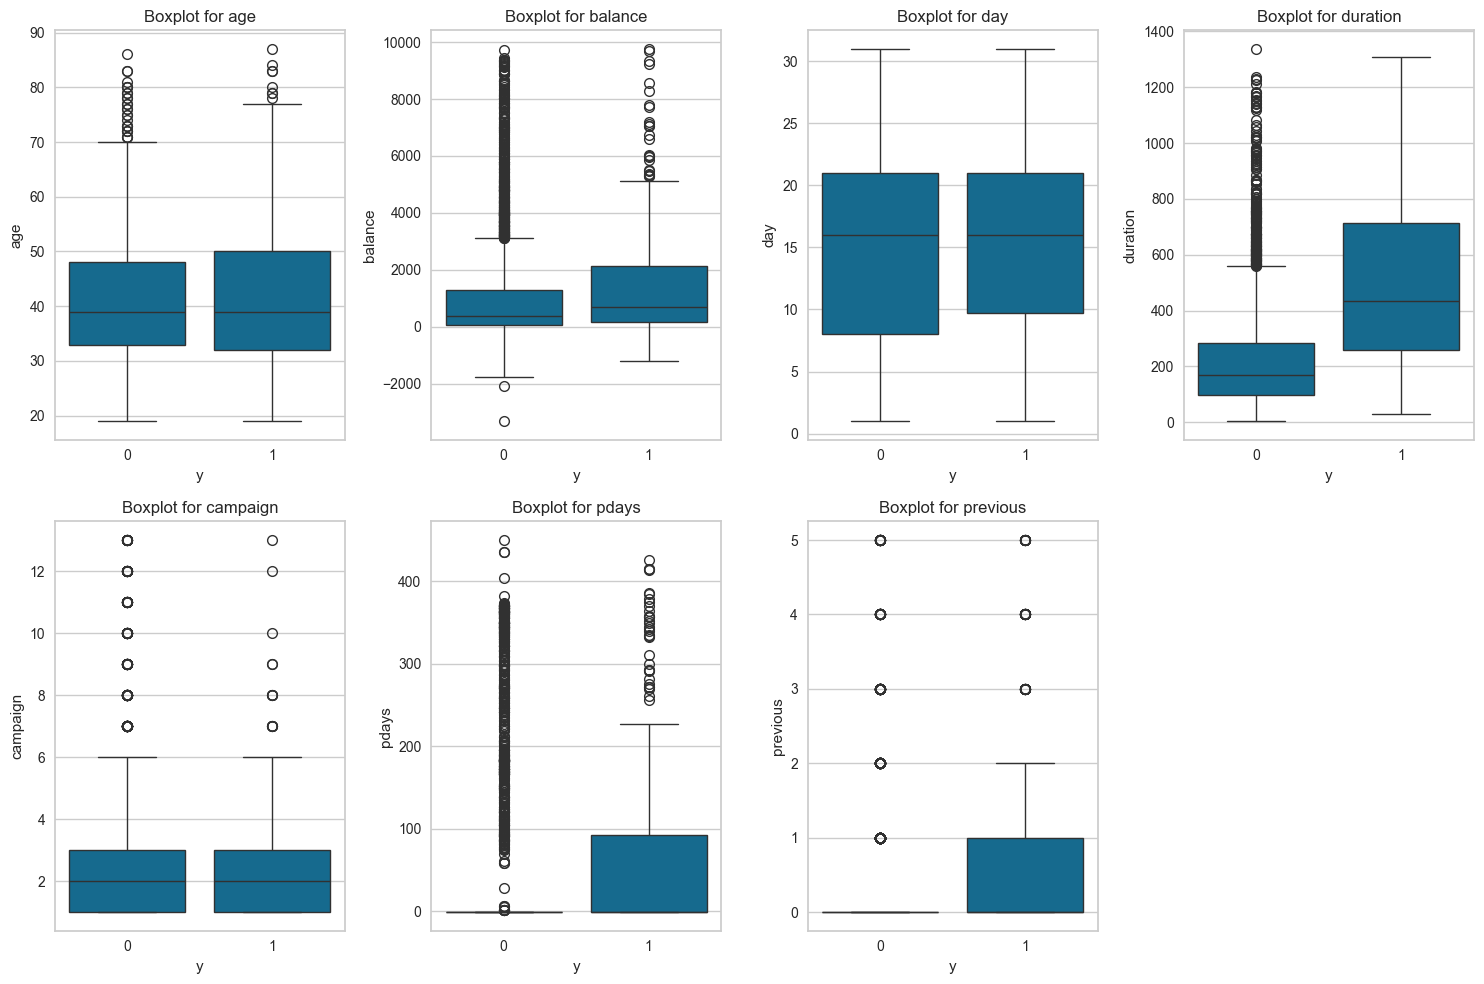

In [70]:
numerical_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# Create subplots with a 3x3 grid for numerical columns
num_rows = 2
num_cols = 4
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 10))

# Flatten the axes array to iterate through it easily
axes = axes.flatten()

# Loop through the numerical columns and create boxplots
for i, col in enumerate(numerical_columns):
    sns.boxplot(x='y', y=col, data=df, ax=axes[i])
    axes[i].set_title(f'Boxplot for {col}')

# Remove empty subplots if there are any
for i in range(len(numerical_columns), num_rows * num_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [71]:
def remove_outliers_iqr(data, numeric_columns, threshold=1.5):
    Q1 = data[numeric_columns].quantile(0.10)
    Q3 = data[numeric_columns].quantile(0.90)
    IQR = Q3 - Q1

    # Find rows containing outliers
    outlier_rows = ((data[numeric_columns] < (Q1 - threshold * IQR)) | (data[numeric_columns] > (Q3 + threshold * IQR))).any(axis=1)

    # Remove rows with outliers
    cleaned_data = data[~outlier_rows]

    return cleaned_data


In [72]:
# Remove outliers using the function
cleaned_dataset = remove_outliers_iqr(df, numerical_columns)
df = pd.DataFrame(cleaned_dataset)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3917 entries, 0 to 4518
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   age        3917 non-null   int64
 1   job        3917 non-null   int32
 2   marital    3917 non-null   int32
 3   education  3917 non-null   int32
 4   default    3917 non-null   int32
 5   balance    3917 non-null   int64
 6   housing    3917 non-null   int32
 7   loan       3917 non-null   int32
 8   contact    3917 non-null   int32
 9   day        3917 non-null   int64
 10  month      3917 non-null   int32
 11  duration   3917 non-null   int64
 12  campaign   3917 non-null   int64
 13  pdays      3917 non-null   int64
 14  previous   3917 non-null   int64
 15  poutcome   3917 non-null   int32
 16  y          3917 non-null   int32
dtypes: int32(10), int64(7)
memory usage: 397.8 KB


In [73]:
scaler = RobustScaler()
df1 = df[numerical_columns]
df2 = df.drop(numerical_columns,axis=1)
robust_df = scaler.fit_transform(df1)
robust_df = pd.DataFrame(robust_df, columns=numerical_columns)
df2 = pd.DataFrame(df2)
robust_df.reset_index(drop=True, inplace=True)
df2.reset_index(drop=True, inplace=True)
df_merges = pd.concat([robust_df, df2], axis=1)
df_merges.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3917 entries, 0 to 3916
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        3917 non-null   float64
 1   balance    3917 non-null   float64
 2   day        3917 non-null   float64
 3   duration   3917 non-null   float64
 4   campaign   3917 non-null   float64
 5   pdays      3917 non-null   float64
 6   previous   3917 non-null   float64
 7   job        3917 non-null   int32  
 8   marital    3917 non-null   int32  
 9   education  3917 non-null   int32  
 10  default    3917 non-null   int32  
 11  housing    3917 non-null   int32  
 12  loan       3917 non-null   int32  
 13  contact    3917 non-null   int32  
 14  month      3917 non-null   int32  
 15  poutcome   3917 non-null   int32  
 16  y          3917 non-null   int32  
dtypes: float64(7), int32(10)
memory usage: 367.3 KB


In [74]:
one_hot_encoded_data = pd.get_dummies(df_merges, columns = ['poutcome','education','marital','month','job'])

In [75]:
one_hot_encoded_data.head()

,age,balance,day,duration,campaign,pdays,previous,default,housing,loan,...,job_2,job_3,job_4,job_5,job_6,job_7,job_8,job_9,job_10,job_11
0,-0.5625,1.118603,0.230769,-0.475113,-0.5,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,-0.2500,0.763607,0.000000,0.004525,-0.5,331.0,1.0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
2,-0.5625,0.865963,-1.000000,0.067873,1.0,0.0,0.0,0,1,1,...,0,0,1,0,0,0,0,0,0,0
3,1.2500,-0.333063,-0.846154,0.190045,-0.5,0.0,0.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,-0.1875,-0.083672,-0.153846,0.710407,-0.5,331.0,2.0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


In [76]:
X= one_hot_encoded_data.drop('y',axis=1)
y= one_hot_encoded_data['y']

In [77]:
# Check the shape of X_resampled
num_rows_X, num_columns_X = X.shape
print(f'X: Number of rows = {num_rows_X}, Number of columns = {num_columns_X}')

# Check the shape of y_resampled
num_rows_y = y.shape[0]
print(f'y: Number of rows = {num_rows_y}')

X: Number of rows = 3917, Number of columns = 46
y: Number of rows = 3917


In [78]:
# using the train test split function
X_train, X_test,y_train, y_test = train_test_split(X,y,random_state=104,test_size=0.25,shuffle=True)

In [79]:
smote = RandomOverSampler()
X_resampled, y_resampled = smote.fit_resample(X, y)

In [80]:
# Check the shape of X_resampled
num_rows_X_resampled, num_columns_X_resampled = X_resampled.shape
print(f'X_resampled: Number of rows = {num_rows_X_resampled}, Number of columns = {num_columns_X_resampled}')

# Check the shape of y_resampled
num_rows_y_resampled = y_resampled.shape[0]
print(f'y_resampled: Number of rows = {num_rows_y_resampled}')

X_resampled: Number of rows = 7038, Number of columns = 46
y_resampled: Number of rows = 7038


In [81]:
s = ClassificationExperiment()
s.setup(data=one_hot_encoded_data, target="y", session_id=1066)
s.compare_models(n_select = 5, sort='Accuracy', fold=5)

,Description,Value
0,Session id,1066
1,Target,y
2,Target type,Binary
3,Original data shape,"(3917, 47)"
4,Transformed data shape,"(3917, 47)"
5,Transformed train set shape,"(2741, 47)"
6,Transformed test set shape,"(1176, 47)"
7,Numeric features,46
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9132,0.9208,0.3368,0.6322,0.4344,0.3932,0.4182,0.8500
gbc,Gradient Boosting Classifier,0.9121,0.9058,0.3548,0.6251,0.4490,0.4055,0.4265,0.1020
lightgbm,Light Gradient Boosting Machine,0.9110,0.9086,0.3619,0.6040,0.4502,0.4055,0.4223,0.2680
ridge,Ridge Classifier,0.9103,0.0000,0.2329,0.6672,0.3428,0.3071,0.3575,0.0160
xgboost,Extreme Gradient Boosting,0.9102,0.9087,0.3762,0.5957,0.4577,0.4119,0.4265,0.3560
lr,Logistic Regression,0.9084,0.8823,0.3010,0.5985,0.3934,0.3511,0.3784,0.6120
rf,Random Forest Classifier,0.9073,0.8942,0.2005,0.6505,0.3002,0.2662,0.3218,0.0740
lda,Linear Discriminant Analysis,0.9062,0.8857,0.4409,0.5584,0.4878,0.4374,0.4437,0.0120
ada,Ada Boost Classifier,0.9037,0.8833,0.3440,0.5510,0.4213,0.3719,0.3854,0.0460
et,Extra Trees Classifier,0.9008,0.8728,0.1719,0.5411,0.2589,0.2211,0.2642,0.0740


 GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                            learning_rate=0.1, loss='log_loss', max_depth=3,
                            max_features=None, max_leaf_nodes=None,
                            min_impurity_decrease=0.0, min_samples_leaf=1,
                            min_samples_split=2, min_weight_fraction_leaf=0.0,
                            n_estimators=100, n_iter_no_change=None,
                            random_state=1066, subsample=1.0, tol=0.0001,
                            validation_fraction=0.1, verbose=0,
                            warm_start=False),
 LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                importance_type='split', learning_rate=0.1, max_depth=-1,
                min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
                random_state=1066, reg_alpha=0.0, reg_la

In [83]:
rf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='sqrt',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_samples_leaf=1,
                        min_samples_split=2, min_weight_fraction_leaf=0.0,
                        n_estimators=100, n_jobs=-1, oob_score=False,
                        random_state=1066, verbose=0, warm_start=False)
rf.fit(X_train, y_train)
# Make predictions
prediction_test = rf.predict(X_test)
print (accuracy_score(y_test, prediction_test))

0.9122448979591836


In [84]:
print(classification_report(y_test, prediction_test))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95       882
           1       0.69      0.22      0.34        98

    accuracy                           0.91       980
   macro avg       0.80      0.61      0.65       980
weighted avg       0.90      0.91      0.89       980



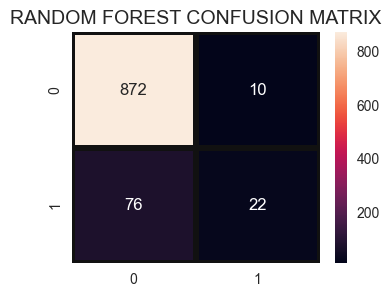

In [85]:
plt.figure(figsize=(4,3))
# Calculate confusion matrix

sns.heatmap(confusion_matrix(y_test, prediction_test),
                annot=True,fmt = "d",linecolor="k",linewidths=3)

plt.title("RANDOM FOREST CONFUSION MATRIX",fontsize=14)
plt.show()

In [108]:
# Make predictions on the test set
predictions = rf.predict(X_test)
conf_matrix = confusion_matrix(y_test, predictions)
# Get True Positive (TP) value
tp_value = conf_matrix[0, 0]  # Assuming '1' corresponds to the positive class
tn_value=conf_matrix[1,1]
print(f'True Positive Score = {tp_value}\nFalse Negative Score = {tn_value}')

True Positive Score = 872
False Negative Score = 22


In [101]:
# using the train test split function
X_train_smote, X_test_smote,y_train_smote, y_test_smote = train_test_split(X_resampled, y_resampled,
                                   random_state=42,
                                   test_size=0.25,
                                   shuffle=True)

In [102]:
rfs = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='sqrt',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_samples_leaf=1,
                        min_samples_split=2, min_weight_fraction_leaf=0.0,
                        n_estimators=100, n_jobs=-1, oob_score=False,
                        random_state=1066, verbose=0, warm_start=False)
rfs.fit(X_train_smote, y_train_smote)
# Make predictions
prediction_test = rfs.predict(X_test_smote)
print (accuracy_score(y_test_smote, prediction_test))

0.9755681818181818


In [89]:
print(classification_report(y_test_smote, prediction_test))

              precision    recall  f1-score   support

           0       1.00      0.95      0.98       888
           1       0.95      1.00      0.98       872

    accuracy                           0.98      1760
   macro avg       0.98      0.98      0.98      1760
weighted avg       0.98      0.98      0.98      1760



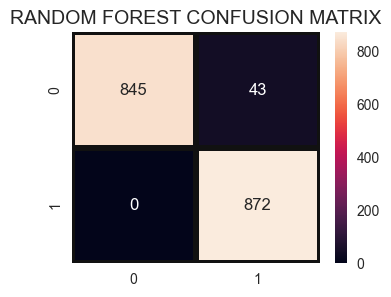

In [90]:
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test_smote, prediction_test),
                annot=True,fmt = "d",linecolor="k",linewidths=3)

plt.title("RANDOM FOREST CONFUSION MATRIX",fontsize=14)
plt.show()

In [109]:
# Make predictions on the test set
predictions = rf.predict(X_test)
conf_matrix = confusion_matrix(y_test_smote, prediction_test)
# Get True Positive (TP) value
tp_value = conf_matrix[0, 0]  # Assuming '1' corresponds to the positive class
tn_value=conf_matrix[1,1]
print(f'True Positive Score = {tp_value}\nFalse Negative Score = {tn_value}')

True Positive Score = 845
False Negative Score = 872


In [91]:
# Get feature importance
feature_importance = rfs.feature_importances_

# Create a DataFrame to display feature importance
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print or visualize feature importance
print(feature_importance_df)

        Feature  Importance
3      duration    0.324771
1       balance    0.087123
0           age    0.079936
2           day    0.071169
10      contact    0.040084
4      campaign    0.038233
8       housing    0.020090
5         pdays    0.019976
13   poutcome_2    0.018836
32     month_10    0.015666
30      month_8    0.015178
9          loan    0.014644
22      month_0    0.014643
20    marital_1    0.014194
27      month_5    0.012021
35        job_1    0.011773
16  education_1    0.011601
17  education_2    0.011405
14   poutcome_3    0.011060
23      month_1    0.010970
21    marital_2    0.010826
38        job_4    0.010051
29      month_7    0.009890
43        job_9    0.009402
6      previous    0.009097
34        job_0    0.008722
31      month_9    0.008640
28      month_6    0.008600
39        job_5    0.008290
15  education_0    0.008185
25      month_3    0.008083
19    marital_0    0.007608
41        job_7    0.006747
11   poutcome_0    0.004710
42        job_8    0